In [1]:
# import os
# os.listdir('../input')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
pd.set_option('display.max_columns',10000); pd.set_option('display.max_rows', 50); np.set_printoptions(threshold=90000)

import sys, os
sys.path.append('../../src/') #モジュールが入っているディレクトリのパスを指定

# import eda
# import config
import maprepro as mpre
import maprepro2 as mpre2



In [2]:
path='../../input/'
# a = pd.read_csv(f'{path}air_reserve.csv',)
asi = pd.read_csv(f'{path}air_store_info.csv',)
avd = pd.read_csv(f'{path}air_visit_data.csv',)
di = pd.read_csv(f'{path}date_info.csv',)
# a = pd.read_csv(f'{path}hpg_reserve.csv',)
# a = pd.read_csv(f'{path}hpg_store_info.csv',)
sa = pd.read_csv(f'{path}sample_submission.csv',)
# a = pd.read_csv(f'{path}store_id_relation.csv',)


In [3]:
'''
- 店ごとに日付ごとの平均を出すと同時にnanを作って0で補完

'''
avd.index = pd.to_datetime(avd['visit_date'])
# # 店ごとに特定の日に何人来たか
avd = avd.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').mean()).reset_index()
# avd.query("air_store_id == 'air_00a91d42b08b08d9'" and "visit_date > '2016-07-01'" )
# filtered_df=df.query("Joined_date >= '2019-06-1' and Joined_date <='2020-02-05'")
avd['visit_date'] = avd['visit_date'].dt.strftime('%Y-%m-%d')
avd['was_nil'] = avd['visitors'].isnull()
avd['visitors'].fillna(0, inplace=True)

avd.head(1)
# avd.shape

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False


In [4]:
# ラグ特徴量作成
date_info = pd.read_csv(f'{path}/date_info.csv')
date_info.rename(columns={'calendar_date': 'visit_date','holiday_flg': 'is_holiday'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head(1)
# date_info.shift()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0


In [5]:
'''
外れ値を適正値の中の最大値に置換
'''
def find_outliers(series):
    # 条件式なのでTrue,falseが返る
    return (series - series.mean()) > 2.4 * series.std()

def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series


stores = avd.groupby('air_store_id')
stores.apply(lambda g: find_outliers(g['visitors'])).values
avd['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values

avd['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
avd['visitors_capped_log1p'] = np.log1p(avd['visitors_capped'])

# avd.query("visit_date > '2016-01-01'" and "visit_date < '2016-01-05'").head(20)

In [6]:
sa['air_store_id'] = sa['id'].str.slice(0, 20)
sa['visit_date'] = sa['id'].str.slice(21)
sa['is_test'] = True
sa['visitors'] = np.nan
sa['test_number'] = range(len(sa))
# sa

In [7]:
'''air_visit+sample_submission+date_info+air_store_info'''

data = pd.concat((avd, sa.drop('id', axis='columns')))
data['is_test'].fillna(False, inplace=True)
data = pd.merge(data, date_info, how='left', left_on=['visit_date'], right_on=['visit_date'])
data = pd.merge(left=data, right=asi, on='air_store_id', how='left')


In [8]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.index = data['visit_date']

# astypeでtrue,false→1,0に変換できる
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day
data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])

In [9]:
'''
air_store_id
visit_date
test_number

is_holiday
prev_day_is_holiday
next_day_is_holiday

air_area_name

latitude
longitude

is_weekend
day_of_month
day_of_week_??
air_genre_name_??

識別フラグ
is_test
was_nil

visitors
is_outlier
visitors_capped
visitors_capped_log1p
'''
data.head(2)

,air_store_id,visit_date,visitors,was_nil,is_outlier,visitors_capped,visitors_capped_log1p,is_test,test_number,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_area_name,latitude,longitude,is_weekend,day_of_month,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food
visit_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-07-01,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,35.0,3.583519,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2016-07-02,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,9.0,2.302585,False,NaN,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
# data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)]
test = data[data['is_test']].sort_values('test_number')

to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name']
        #    'visitors_capped_log1p']
# to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
#            'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
#            'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
#            'station_great_circle', 'visitors_capped_log1p']
train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')

# X_train = train.drop('visitors_log1p', axis='columns')
X_train = train.drop('visitors_capped_log1p', axis='columns')
X_test = test.drop('visitors_capped_log1p', axis='columns')
# X_test = test.drop('visitors_log1p', axis='columns')
# y_train = train['visitors_log1p']
y_train = train['visitors_capped_log1p']

In [11]:
import hashlib

class TunerCVCheckpointCallback(object):
    """Optuna の LightGBMTunerCV から学習済みモデルを取り出すためのコールバック"""

    def __init__(self):
        # オンメモリでモデルを記録しておく辞書
        self.cv_boosters = {}

    @staticmethod
    def params_to_hash(params):
        """パラメータを元に辞書のキーとなるハッシュを計算する"""
        # params_hash = hash((frozenset(params.items())))
        params_hash = hashlib.sha512(str(frozenset(params.items())).encode()).hexdigest()
        return params_hash

    def get_trained_model(self, params):
        """パラメータをキーとして学習済みモデルを取り出す"""
        params_hash = self.params_to_hash(params)
        return self.cv_boosters[params_hash]

    def __call__(self, env):
        """LightGBM の各ラウンドで呼ばれるコールバック"""
        # 学習に使うパラメータをハッシュ値に変換する
        params_hash = self.params_to_hash(env.params)
        # 初登場のパラメータならモデルへの参照を保持する
        if params_hash not in self.cv_boosters:
            self.cv_boosters[params_hash] = env.model
        # else:
        #     print(f'{params_hash}が衝突しました'*2)
        #     self.cv_boosters[params_hash] = env.model
    

In [12]:
from optuna.integration import lightgbm as lgb
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection


np.random.seed(0)

n_splits = 2

# val_scores = [0] * n_splits

sub = sa['id'].to_frame()
sub['visitors'] = 0

feature_importances = pd.DataFrame(index=X_train.columns)

# デモ用にデータセットを分割する
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    shuffle=True,
                                                    random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

folds = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=0)

# 学習済みモデルへの参照を保持するためのコールバック
checkpoint_cb = TunerCVCheckpointCallback()
callbacks = [
    checkpoint_cb,
]

lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
}

tuner_cv = lgb.LightGBMTunerCV(
    lgbm_params, lgb_train,
    # num_boost_round=3,
    # early_stopping_rounds=1,
    # verbose_eval=20,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=200,
    folds=folds,
    callbacks=callbacks,
)

tuner_cv.run()
# NOTE: 念のためハッシュの衝突に備えて Trial の数と学習済みモデルの数を比較しておく
assert len(checkpoint_cb.cv_boosters) == len(tuner_cv.study.trials)
# assert len(checkpoint_cb.cv_boosters) == len(tuner_cv.study.trials) - 1
    
# 最も良かったパラメータをキーにして学習済みモデルを取り出す
cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)
# Averaging でホールドアウト検証データを予測する
# y_pred_proba_list = cv_booster.predict(X_test,
#                                         num_iteration=cv_booster.best_iteration)
# y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
# y_pred = np.where(y_pred_proba_avg > 0.5, 1, 0)

# sub['visitors'] /= n_splits
# sub['visitors'] = np.expm1(sub['visitors'])

# val_mean = np.mean(val_scores)
# val_std = np.std(val_scores)

# print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))


[I 2021-08-15 14:56:17,515] A new study created in memory with name: no-name-1011e445-7284-4248-a0c2-3480b3df9527
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[200]	cv_agg's rmse: 0.693925 + 0.00181008
[400]	cv_agg's rmse: 0.691452 + 0.00117919


feature_fraction, val_score: 0.691420:  14%|#4        | 1/7 [00:01<00:08,  1.48s/it]

[200]	cv_agg's rmse: 0.695734 + 0.00139292
[400]	cv_agg's rmse: 0.690728 + 0.00149234
[600]	cv_agg's rmse: 0.689666 + 0.00123181


feature_fraction, val_score: 0.689402:  29%|##8       | 2/7 [00:04<00:11,  2.20s/it]

[800]	cv_agg's rmse: 0.689559 + 0.00116147
[200]	cv_agg's rmse: 0.693213 + 0.00139183
[400]	cv_agg's rmse: 0.690636 + 0.00108303


feature_fraction, val_score: 0.689402:  43%|####2     | 3/7 [00:05<00:07,  1.96s/it]

[200]	cv_agg's rmse: 0.693331 + 0.000860684
[400]	cv_agg's rmse: 0.690436 + 0.00126404


feature_fraction, val_score: 0.689402:  57%|#####7    | 4/7 [00:07<00:05,  1.90s/it]

[200]	cv_agg's rmse: 0.694512 + 0.00132587
[400]	cv_agg's rmse: 0.690642 + 0.0014476


feature_fraction, val_score: 0.689402:  71%|#######1  | 5/7 [00:09<00:03,  1.95s/it]

[600]	cv_agg's rmse: 0.690074 + 0.00109047
[200]	cv_agg's rmse: 0.693689 + 0.000822431
[400]	cv_agg's rmse: 0.690809 + 0.00121393


feature_fraction, val_score: 0.689402:  86%|########5 | 6/7 [00:11<00:01,  1.82s/it]

[200]	cv_agg's rmse: 0.694086 + 0.00134085
[400]	cv_agg's rmse: 0.69009 + 0.000993055


num_leaves, val_score: 0.688779:   5%|5         | 1/20 [00:02<00:45,  2.41s/it]

[200]	cv_agg's rmse: 0.70585 + 0.00109744
[400]	cv_agg's rmse: 0.697269 + 0.000862543
[600]	cv_agg's rmse: 0.693168 + 0.00117661
[800]	cv_agg's rmse: 0.69129 + 0.00120267


num_leaves, val_score: 0.688779:  10%|#         | 2/20 [00:04<00:41,  2.32s/it]

[1000]	cv_agg's rmse: 0.690267 + 0.000941354


num_leaves, val_score: 0.688755:  15%|#5        | 3/20 [00:06<00:37,  2.21s/it]

[200]	cv_agg's rmse: 0.691062 + 0.00121049
[400]	cv_agg's rmse: 0.688951 + 0.000915173


num_leaves, val_score: 0.688755:  20%|##        | 4/20 [00:09<00:36,  2.26s/it]

[200]	cv_agg's rmse: 0.689183 + 0.00104795


num_leaves, val_score: 0.688574:  25%|##5       | 5/20 [00:11<00:34,  2.28s/it]

[200]	cv_agg's rmse: 0.688978 + 0.00116748


num_leaves, val_score: 0.688574:  30%|###       | 6/20 [00:13<00:31,  2.22s/it]

[200]	cv_agg's rmse: 0.690267 + 0.00118323


num_leaves, val_score: 0.688574:  35%|###5      | 7/20 [00:15<00:28,  2.18s/it]

[400]	cv_agg's rmse: 0.689261 + 0.0010827
[200]	cv_agg's rmse: 0.688962 + 0.00111025


num_leaves, val_score: 0.688454:  40%|####      | 8/20 [00:17<00:26,  2.21s/it]

[200]	cv_agg's rmse: 0.689257 + 0.00103511


num_leaves, val_score: 0.688454:  45%|####5     | 9/20 [00:20<00:24,  2.22s/it]

[200]	cv_agg's rmse: 0.691438 + 0.0016258
[400]	cv_agg's rmse: 0.689392 + 0.00127461


num_leaves, val_score: 0.688454:  50%|#####     | 10/20 [00:22<00:22,  2.24s/it]

[200]	cv_agg's rmse: 0.688921 + 0.00119474


num_leaves, val_score: 0.688454:  55%|#####5    | 11/20 [00:24<00:20,  2.25s/it]

[200]	cv_agg's rmse: 0.689154 + 0.00122355


num_leaves, val_score: 0.688454:  60%|######    | 12/20 [00:27<00:18,  2.27s/it]

[200]	cv_agg's rmse: 0.688813 + 0.00107092


num_leaves, val_score: 0.688454:  65%|######5   | 13/20 [00:29<00:16,  2.31s/it]

[200]	cv_agg's rmse: 0.689515 + 0.00129842


num_leaves, val_score: 0.688454:  70%|#######   | 14/20 [00:32<00:14,  2.44s/it]

[200]	cv_agg's rmse: 0.688577 + 0.000969502


num_leaves, val_score: 0.688454:  75%|#######5  | 15/20 [00:34<00:12,  2.42s/it]

[200]	cv_agg's rmse: 0.688687 + 0.000948244


num_leaves, val_score: 0.688454:  85%|########5 | 17/20 [00:38<00:06,  2.29s/it]

[200]	cv_agg's rmse: 0.688984 + 0.00129767


num_leaves, val_score: 0.688454:  90%|######### | 18/20 [00:41<00:04,  2.29s/it]

[200]	cv_agg's rmse: 0.688707 + 0.00138242


num_leaves, val_score: 0.688454:  95%|#########5| 19/20 [00:43<00:02,  2.26s/it]

[200]	cv_agg's rmse: 0.688981 + 0.00105195


bagging, val_score: 0.688454:   0%|          | 0/10 [00:00<?, ?it/s]

[200]	cv_agg's rmse: 0.689209 + 0.00104891


bagging, val_score: 0.688454:  10%|#         | 1/10 [00:02<00:23,  2.66s/it]

[200]	cv_agg's rmse: 0.690262 + 0.000862447


bagging, val_score: 0.688454:  20%|##        | 2/10 [00:05<00:20,  2.59s/it]

[200]	cv_agg's rmse: 0.689319 + 0.00101059


bagging, val_score: 0.688454:  30%|###       | 3/10 [00:07<00:17,  2.57s/it]

[200]	cv_agg's rmse: 0.691629 + 0.00112067


bagging, val_score: 0.688454:  40%|####      | 4/10 [00:10<00:15,  2.50s/it]

[200]	cv_agg's rmse: 0.689187 + 0.00123141


bagging, val_score: 0.688454:  50%|#####     | 5/10 [00:12<00:12,  2.49s/it]

[200]	cv_agg's rmse: 0.690028 + 0.000972891


bagging, val_score: 0.688454:  60%|######    | 6/10 [00:15<00:10,  2.52s/it]

[200]	cv_agg's rmse: 0.690405 + 0.00114395


bagging, val_score: 0.688454:  70%|#######   | 7/10 [00:17<00:07,  2.48s/it]

[200]	cv_agg's rmse: 0.68926 + 0.00094927


bagging, val_score: 0.688454:  80%|########  | 8/10 [00:20<00:04,  2.48s/it]

[200]	cv_agg's rmse: 0.6897 + 0.000910395


bagging, val_score: 0.688454:  90%|######### | 9/10 [00:22<00:02,  2.52s/it]

[200]	cv_agg's rmse: 0.690409 + 0.000957672


feature_fraction_stage2, val_score: 0.688454:   0%|          | 0/3 [00:00<?, ?it/s]

[200]	cv_agg's rmse: 0.690191 + 0.00104189


feature_fraction_stage2, val_score: 0.688454:  33%|###3      | 1/3 [00:02<00:04,  2.47s/it]

[200]	cv_agg's rmse: 0.689502 + 0.0010033


feature_fraction_stage2, val_score: 0.688454:  67%|######6   | 2/3 [00:04<00:02,  2.42s/it]

[200]	cv_agg's rmse: 0.690191 + 0.00104189


regularization_factors, val_score: 0.688454:   0%|          | 0/20 [00:00<?, ?it/s]

[200]	cv_agg's rmse: 0.689224 + 0.000828532


regularization_factors, val_score: 0.688454:   5%|5         | 1/20 [00:02<00:52,  2.76s/it]

[200]	cv_agg's rmse: 0.688913 + 0.00109309


regularization_factors, val_score: 0.688454:  10%|#         | 2/20 [00:05<00:46,  2.57s/it]

[200]	cv_agg's rmse: 0.68893 + 0.00119822


regularization_factors, val_score: 0.688454:  15%|#5        | 3/20 [00:07<00:41,  2.44s/it]

[200]	cv_agg's rmse: 0.688986 + 0.00114164


regularization_factors, val_score: 0.688454:  20%|##        | 4/20 [00:09<00:37,  2.37s/it]

[200]	cv_agg's rmse: 0.689073 + 0.00109109


regularization_factors, val_score: 0.688454:  25%|##5       | 5/20 [00:12<00:35,  2.37s/it]

[200]	cv_agg's rmse: 0.688931 + 0.000995424


regularization_factors, val_score: 0.688454:  30%|###       | 6/20 [00:14<00:32,  2.33s/it]

[200]	cv_agg's rmse: 0.689047 + 0.00103172


regularization_factors, val_score: 0.688454:  35%|###5      | 7/20 [00:16<00:29,  2.26s/it]

[200]	cv_agg's rmse: 0.688711 + 0.00103325


regularization_factors, val_score: 0.688454:  40%|####      | 8/20 [00:19<00:28,  2.39s/it]

[200]	cv_agg's rmse: 0.689042 + 0.00102547


regularization_factors, val_score: 0.688454:  45%|####5     | 9/20 [00:21<00:25,  2.35s/it]

[200]	cv_agg's rmse: 0.688893 + 0.00110199


regularization_factors, val_score: 0.688375:  50%|#####     | 10/20 [00:23<00:23,  2.30s/it]

[200]	cv_agg's rmse: 0.688957 + 0.00108252


regularization_factors, val_score: 0.688375:  55%|#####5    | 11/20 [00:25<00:20,  2.27s/it]

[200]	cv_agg's rmse: 0.688973 + 0.00109882


regularization_factors, val_score: 0.688375:  60%|######    | 12/20 [00:28<00:18,  2.26s/it]

[200]	cv_agg's rmse: 0.688986 + 0.0011662


regularization_factors, val_score: 0.688375:  65%|######5   | 13/20 [00:30<00:15,  2.22s/it]

[200]	cv_agg's rmse: 0.688931 + 0.000995424


regularization_factors, val_score: 0.688375:  70%|#######   | 14/20 [00:32<00:13,  2.21s/it]

[200]	cv_agg's rmse: 0.688971 + 0.00104511


regularization_factors, val_score: 0.688375:  75%|#######5  | 15/20 [00:34<00:11,  2.21s/it]

[200]	cv_agg's rmse: 0.689082 + 0.000984598


regularization_factors, val_score: 0.688375:  80%|########  | 16/20 [00:36<00:08,  2.23s/it]

[200]	cv_agg's rmse: 0.688906 + 0.000992733


regularization_factors, val_score: 0.688375:  85%|########5 | 17/20 [00:39<00:06,  2.24s/it]

[200]	cv_agg's rmse: 0.688929 + 0.0010941


regularization_factors, val_score: 0.688375:  90%|######### | 18/20 [00:41<00:04,  2.22s/it]

[200]	cv_agg's rmse: 0.688961 + 0.000964465


regularization_factors, val_score: 0.688375:  95%|#########5| 19/20 [00:43<00:02,  2.22s/it]

[200]	cv_agg's rmse: 0.688879 + 0.000989497


min_data_in_leaf, val_score: 0.688375:   0%|          | 0/5 [00:00<?, ?it/s]

[200]	cv_agg's rmse: 0.689427 + 0.00111948


min_data_in_leaf, val_score: 0.688375:  20%|##        | 1/5 [00:02<00:09,  2.30s/it]

[200]	cv_agg's rmse: 0.689247 + 0.00103096


min_data_in_leaf, val_score: 0.688375:  40%|####      | 2/5 [00:04<00:06,  2.23s/it]

[200]	cv_agg's rmse: 0.689449 + 0.00120172


min_data_in_leaf, val_score: 0.688375:  60%|######    | 3/5 [00:06<00:04,  2.20s/it]

[200]	cv_agg's rmse: 0.689979 + 0.00113645


min_data_in_leaf, val_score: 0.688375:  80%|########  | 4/5 [00:09<00:02,  2.29s/it]

[200]	cv_agg's rmse: 0.688995 + 0.00124968


min_data_in_leaf, val_score: 0.688375: 100%|##########| 5/5 [00:11<00:00,  2.27s/it]


KeyError: 'e1f0069617336b30f32f256d62fa64d023b0047f865e77d6a95de212da9f273762f933a90ccbf55c465b8f04ad92a0394a9908e18bd23dc59c74e379ed7ab5d2'

In [13]:
best_params = tuner_cv.best_params
# best_params

In [14]:
sub = sa['id'].to_frame()
sub['visitors'] = 0

X_train = train.drop('visitors_capped_log1p', axis='columns')
y_train = train['visitors_capped_log1p']
X_test = test.drop('visitors_capped_log1p', axis='columns')

model = lgbm.LGBMRegressor(**best_params)

model.fit(
    X_train,
    y_train,
    verbose=False
)

sub['visitors'] = model.predict(X_test)
sub['visitors'] = np.expm1(sub['visitors'])
sub


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,17.828903
1,air_00a91d42b08b08d9_2017-04-24,17.990370
2,air_00a91d42b08b08d9_2017-04-25,19.115328
3,air_00a91d42b08b08d9_2017-04-26,22.819473
4,air_00a91d42b08b08d9_2017-04-27,22.749772
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,12.566533
32015,air_fff68b929994bfbd_2017-05-28,9.841335
32016,air_fff68b929994bfbd_2017-05-29,5.761853
32017,air_fff68b929994bfbd_2017-05-30,6.511289


In [21]:
%matplotlib inline
import shap
shap.initjs()
X_test = shap.sample(X_test, 1000)
explainer = shap.TreeExplainer(model, data=X_test)
# Consider using shap.sample(data, 100) to create a smaller background data set.


100%|===================| 998/1000 [01:00<00:00]       

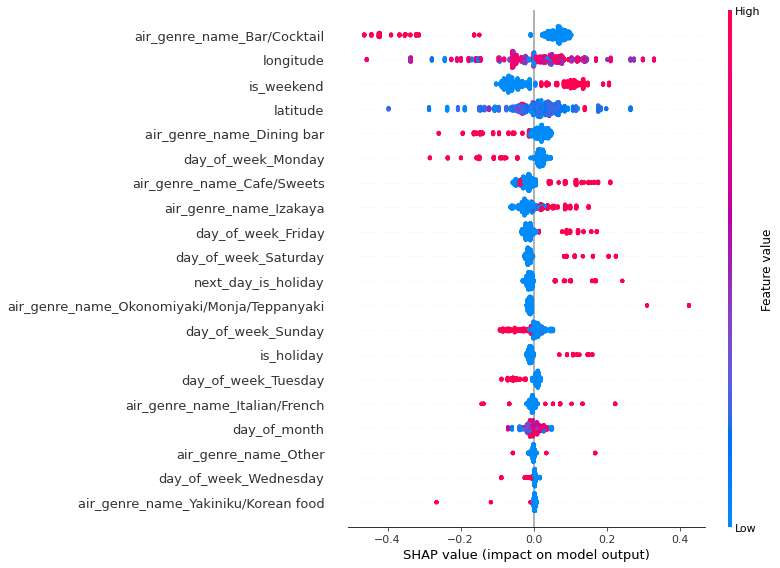

In [22]:

# そして、TreeExplainer を使って、モデルがどのように推論するか解釈したいデータについて SHAP Value を計算しよう。
# この SHAP Value は、入力したのと同じ次元と要素数で得られる。 そして、値が大きいほど推論において影響が大きいと見なすことができる。
tr_x_shap_values = explainer.shap_values(X_test)
# つまり、行方向に見れば「特定の予測に、それぞれの特徴量がどれくらい寄与したか」と解釈できる。 
# 同様に、列方向に見れば「予測全体で、その特徴量がどれくらい寄与したか」と解釈できる。

# SHAP Value は自分で可視化しても良いけど、組み込みでいくつかグラフを描画する仕組みが用意されている。 ここからは、それらを使い分けなどと共に見ていこう。
# Summary Plot
# はじめに、Summary Plot から。 このグラフは、デフォルトでは特徴量ごとに SHAP Value を一軸の散布図として描画する。

shap.summary_plot(shap_values=tr_x_shap_values,
                  features=X_test,
                  feature_names=X_test.columns)


In [23]:
NOW = mpre2.mk_now()

In [24]:
# missing_values_table(sub)
sub.to_csv(f'../../output/{NOW}.csv',index=False)
tmp = pd.read_csv(f'../../output/{NOW}.csv')
tmp

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,16.867877
1,air_00a91d42b08b08d9_2017-04-24,17.146119
2,air_00a91d42b08b08d9_2017-04-25,19.159523
3,air_00a91d42b08b08d9_2017-04-26,22.896897
4,air_00a91d42b08b08d9_2017-04-27,22.863047
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,12.106317
32015,air_fff68b929994bfbd_2017-05-28,9.426751
32016,air_fff68b929994bfbd_2017-05-29,5.953320
32017,air_fff68b929994bfbd_2017-05-30,6.671103


In [ ]:
aggregation = {'visitors' : 'median'}
vagg = v.groupby(['air_store_id','dow']).agg(aggregation).reset_index()
vagg

,air_store_id,dow,visitors
0,air_00a91d42b08b08d9,0,19.0
1,air_00a91d42b08b08d9,1,24.5
2,air_00a91d42b08b08d9,2,28.0
3,air_00a91d42b08b08d9,3,30.0
4,air_00a91d42b08b08d9,4,35.5
...,...,...,...
5736,air_fff68b929994bfbd,2,4.0
5737,air_fff68b929994bfbd,3,4.0
5738,air_fff68b929994bfbd,4,5.0
5739,air_fff68b929994bfbd,5,7.0


In [ ]:

# submitのヘッダー情報
missing_values_table(submit)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,341,1.1


# 検証コード

<AxesSubplot:ylabel='Frequency'>

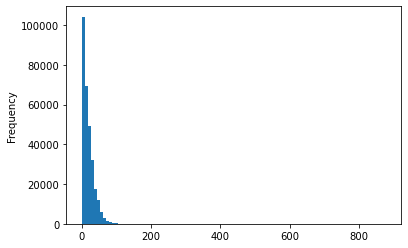

In [ ]:
# 売り上げが正規分布に従っているか検証、１店舗ごとにプロットすると正規分布に従うことがわかる
tmp = air_visit.query("air_store_id == 'air_00a91d42b08b08d9'")
# tmp['visitors'].plot.hist(bins=100)
# air_visit['visitors'].plot.hist(bins=100)

In [ ]:
cv.split(X_train, y_train)

In [ ]:
# hashlib.md5(b"1").digest()
import hashlib
# dat = frozenset(tuner_cv.best_params.items())
# SHA512のハッシュ値
# hs = hashlib.sha1()
hashlib.sha1(str(frozenset(tuner_cv.best_params.items())).encode().hexdigest())
# hs = hashlib.sha224(frozenset(tuner_cv.best_params.items()))
# hs = hashlib.sha224(dat.encode()).hexdigest()
# print(hs)
# dat


In [ ]:
# tuner_cv.best_score
# tuner_cv.best_params
# checkpoint_cb.cv_boosters[4115625917578661725]

len(checkpoint_cb.cv_boosters)
# len(tuner_cv.study.trials)
# checkpoint_cb.get_trained_model(tuner_cv.best_params)
# checkpoint_cb.cv_boosters.keys()
# # tuner_cv.best_params
# cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)
